In [46]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import cma
import numba
import os

In [47]:
#params
##data
amp, centre, sigma = (0.6969641043116005, 1.4904524578404597, 1.3102271681828053)

x_data = [0, 3, 6, 10, 20]

Aktp_data = [1.6, 2.3, 1.87, 1.8, 0.66]
Agop_data = [1.5, 2.6, 2.9, 2.1, 0.79]
Agopgw_data = [1.2, 1.5, 2.85, 2.15, 1.07]

Aktp_data_SEM = [0.17, 0.19, 0.26, 0.7, 0.27]
Agop_data_SEM = [0.22, 0.57, 0.23, 0.17, 0.42]
Agopgw_data_SEM = [0.0, 0.11, 0.21, 0.18, 0.17]

x_data2 = [-60, -30, -5, 0, 3, 6, 10, 20]

Aktp_data2 = [1, 1, 1, 1.6, 2.3, 1.87, 1.8, 0.66]
Agop_data2 = [1, 1, 1, 1.5, 2.6, 2.9, 2.1, 0.79]
Agopgw_data2 = [1, 1, 1, 1.2, 1.5, 2.85, 2.15, 1.07]

Aktp_data_SEM2 = [0.32, 0.32, 0.32, 0.17, 0.19, 0.26, 0.7, 0.27]
Agop_data_SEM2 = [0.32, 0.32, 0.32, 0.22, 0.57, 0.23, 0.17, 0.42]
Agopgw_data_SEM2 = [0.36, 0.36, 0.36, 0.0, 0.11, 0.21, 0.18, 0.17]

data = np.array([[Aktp_data], [Agop_data], [Agopgw_data]])
data_sem = np.array([[Aktp_data_SEM], [Agop_data_SEM], [Agopgw_data_SEM]])

data2 = np.array([[Aktp_data2], [Agop_data2], [Agopgw_data2]])
data_sem2 = np.array([[Aktp_data_SEM2], [Agop_data_SEM2], [Agopgw_data_SEM2]])

nmda_x = [108.77762801045833-120, 125.66705100930517-120, 147.06140279649867-120, 168.61165694983492-120, 188.7003264205789-120, 208.8734430063173-120, 224.78198028484644-120, 252.21430079412767-120, 266.70672491352275-120, 292.67421277425-120, 308.54702242720464-120, 327.3170177176539-120, 350.40031180473215-120, 369.15731523133604-120,]
nmda_y = [0.2911963882618509, 0.5530474040632054, 0.6839729119638827, 0.7065462753950338, 0.7449209932279908, 0.7246049661399547, 0.6681715575620766, 0.6027088036117381, 0.5304740406320541, 0.4830699774266365, 0.4514672686230248, 0.4063205417607221, 0.3634311512415347, 0.3273137697516928,]
nmda_sem = [0.3702031602708802, 0.6817155756207673, 0.8600451467268622, 0.8893905191873588, 0.9638826185101579, 0.9480812641083518, 0.8781038374717831, 0.8239277652370203, 0.7223476297968396, 0.6681715575620766, 0.6094808126410833, 0.5643340857787809, 0.5079006772009027, 0.46275395033860045]
nmda_sem = np.array(nmda_sem) - np.array(nmda_y)
nmda_x = np.array(nmda_x) / 60

nmda_y = np.array(nmda_y)

##others
dt = 0.01
minutes = 20
numtimesteps = minutes/dt #100

#rate constants
k1 = 1 #0.4513
k_1 = 1 #0.1
k2 = 1 #0.1332
k_2 = 1 #6.65
k3 = 1 #0.3925
k_3 = 1 #0.2
k4 = 1 #0.017 #* 10
k_4 = 1 #0.017 #* 0
k5 = 1 #0.35 #* 0
k_5 = 1 #0.017 #* 0

Akt_init = 1 #0.686
Aktpb_init = 1 #0
Aktpf_init = 1 #0
Ago_init = 1 #78
Agop_init = 1 #0
Gw_init = 1 #0.71
Agopgw_init = 1 #0

rates = [k1, k_1, k2, k_2, k3, k_3]
inits = [Akt_init, Aktpb_init,  Ago_init, Agop_init, Gw_init, Agopgw_init]

theta = np.array(rates + inits)

beg = 0
beg2 = -10

In [48]:
#gaussian function
def gauss(x, amp, centre, sigma):
    return amp*np.exp(-(x - centre)**2 / (2*sigma)**2) 

In [49]:
#first simple model function

@numba.jit()
def model1(theta):
    
    def gauss(x, amp, centre, sigma):
        return amp*np.exp(-(x - centre)**2 / (2*sigma)**2) 
    
    k1, k_1, k2, k_2, k3, k_3, Akt0, Aktp0, Ago0, Agop0, Gw0, Agopgw0 = np.exp(theta)
    
    Akt = np.zeros(int((minutes - beg)/dt))
    Aktp = np.zeros(int((minutes - beg)/dt))
    Ago = np.zeros(int((minutes - beg)/dt))
    Agop = np.zeros(int((minutes - beg)/dt))
    Gw = np.zeros(int((minutes - beg)/dt))
    Agopgw = np.zeros(int((minutes - beg)/dt))
    time = np.linspace(int(beg), int(minutes), int((minutes-beg)/dt))
    
    NMDA = gauss(time, amp, centre, sigma)
    
    Akt[0] = Akt0
    Aktp[0] = Aktp0
    Ago[0] = Ago0
    Agop[0] = Agop0
    Gw[0] = Gw0
    Agopgw[0] = Agopgw0
    
    for i in range(1, int((minutes-beg)/dt)):
        Akt[i] = Akt[i-1] + dt*(Aktp[i-1]*k_1 - Akt[i-1]*k1*NMDA[i])
        Aktp[i] = Aktp[i-1] + dt*(Akt[i-1]*k1*NMDA[i] - Aktp[i-1]*k_1)
        Ago[i] = Ago[i-1] + dt*(Agop[i-1]*k_2 - Aktp[i-1]*Ago[i-1]*k2)
        Agop[i] = Agop[i-1] + dt*(Aktp[i-1]*Ago[i-1]*k2 + Agopgw[i-1]*k_3 - Agop[i-1]*k_2 - Agop[i-1]*Gw[i-1]*k3)
        Gw[i] = Gw[i-1] + dt*(Agopgw[i-1]*k_3 - Agop[i-1]*Gw[i-1]*k3)
        Agopgw[i] = Agopgw[i-1] + dt*(Agop[i-1]*Gw[i-1]*k3 - Agopgw[i-1]*k_3)
        
    return Akt, Aktp, Ago, Agop, Gw, Agopgw, NMDA, time

In [50]:
#first simple model function fc calculation
def foldChange1(theta):
    Akt, Aktp, Ago, Agop, Gw, Agopgw, NMDA, time = model1(theta)
    
    Aktp_fold = np.zeros(len(Akt))
    Agop_fold = np.zeros(len(Akt))
    Agopgw_fold = np.zeros(len(Akt))
    
    for i in range(len(Akt)):
            Aktp_fold[i] = Aktp[i] / ( Aktp[0] )#+ Akt[0]) / akcont
            Agop_fold[i] = (Agop[i] + Agopgw[i]) / ( Agop[0]  + Agopgw[0] )#+ Ago[0] ) / agcont
            Agopgw_fold[i] = Agopgw[i] / ( Agopgw[0] )#+ Gw[0]) / gwcont
            
    return Aktp_fold, Agop_fold, Agopgw_fold, time 

In [51]:
def error1(theta):
    Aktp_fold, Agop_fold, Agopgw_fold, time = foldChange1(theta)
    
    aktp_model = list(np.interp(x_data, time, Aktp_fold))
    agop_model = list(np.interp(x_data, time, Agop_fold))
    agopgw_model = list(np.interp(x_data, time, Agopgw_fold))
    
    model = np.array([[aktp_model], [agop_model], [agopgw_model]])
    
    return np.sum((data - model)**2)

In [52]:
res1c = cma.fmin(error1, theta, 2)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=856296, Fri Aug 16 08:06:14 2024)


C:\Users\Sofia\AppData\Local\Temp/ipykernel_14112/1358991569.py:11: RuntimeWarning: invalid value encountered in double_scalars
  Agop_fold[i] = (Agop[i] + Agopgw[i]) / ( Agop[0]  + Agopgw[0] )#+ Ago[0] ) / agcont


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 1.122146852338417e+01 1.0e+00 1.84e+00  2e+00  2e+00 0:00.0
    2     22 1.132694324896767e+01 1.1e+00 1.79e+00  2e+00  2e+00 0:00.0
    3     33 1.201771062289303e+01 1.2e+00 1.71e+00  2e+00  2e+00 0:00.1


C:\Users\Sofia\AppData\Local\Temp/ipykernel_14112/1358991569.py:11: RuntimeWarning: invalid value encountered in double_scalars
  Agop_fold[i] = (Agop[i] + Agopgw[i]) / ( Agop[0]  + Agopgw[0] )#+ Ago[0] ) / agcont
C:\Users\Sofia\AppData\Local\Temp/ipykernel_14112/383076879.py:10: RuntimeWarning: overflow encountered in square
  return np.sum((data - model)**2)


  100   1100 6.885287416109970e+00 9.7e+00 1.80e-01  1e-01  2e-01 0:02.2
  200   2200 6.724339960182833e+00 9.6e+01 3.01e-01  2e-01  5e-01 0:04.1
  300   3300 6.536753848460263e+00 1.8e+02 4.81e-01  1e-01  9e-01 0:06.2
  400   4400 4.312259401421336e+00 1.8e+02 9.71e-01  2e-01  1e+00 0:08.1


C:\Users\Sofia\AppData\Local\Temp/ipykernel_14112/1358991569.py:12: RuntimeWarning: overflow encountered in double_scalars
  Agopgw_fold[i] = Agopgw[i] / ( Agopgw[0] )#+ Gw[0]) / gwcont


  500   5500 2.756239703936018e+00 4.1e+02 9.66e-01  7e-02  2e+00 0:10.0
  600   6600 2.602168908172369e+00 2.0e+03 5.04e-01  1e-02  3e+00 0:11.9
  700   7700 2.535384451993825e+00 9.5e+03 3.35e-01  4e-03  4e+00 0:13.7
NOTE (module=cma, iteration=788):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 1.6e+10 to 9.3e+09
  800   8800 2.534971919393219e+00 9.9e+04 4.83e-02  2e-04  2e+00 0:15.6


C:\Users\Sofia\anaconda3\lib\site-packages\cma\utilities\utils.py:347: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=878)
  warnings.warn(msg + ' (' +


  900   9900 2.534969019950410e+00 2.9e+00 2.15e-02  2e-02  3e-02 0:17.4
 1000  11000 2.502714653592502e+00 1.2e+01 2.93e-02  2e-02  4e-02 0:19.3
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
 1100  12100 2.502536060193703e+00 2.1e+02 1.51e-02  9e-03  3e-02 0:21.1
 1200  13200 2.500819488640767e+00 2.7e+03 2.57e-03  1e-03  4e-03 0:23.0
 1300  14300 2.500801260854741e+00 2.5e+04 2.10e-03  1e-03  3e-03 0:24.9
 1400  15400 2.500677177528104e+00 4.6e+05 1.32e-02  1e-02  5e-02 0:26.7
 1500  16500 2.497238394049467e+00 1.1e+06 7.37e-02  4e-02  2e-01 0:28.6
 1600  17600 2.497053885132115e+00 8.1e+06 2.02e-01  1e-01  6e-01 0:30.4
 1617  17787 2.497046807741762e+00 1.0e+07 1.29e-01  6e-02  3e-01 0:30.7
termination on tolconditioncov=100000000000000.0 (Fri Aug 16 08:06:49 2024)
final/bestever f-value = 2.497049e+00 2.497047e+00 after 17788/17787 evaluations
incumbent solution: [ -25.05157275   -2.45281152   37.92905227    0.63114598  356.23287414
 -564.89179506  -29.789

In [53]:
os.renames('outcmaes', 'outcmaes_all-optim3')

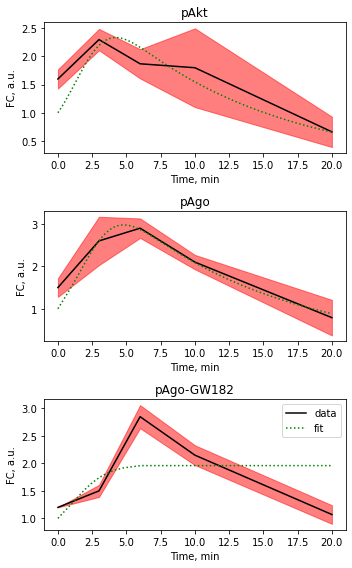

In [55]:
fig, ax = plt.subplots(3, figsize = (5, 8))

Aktp_fold, Agop_fold, Agopgw_fold, time  = foldChange1(res1c[0])

for i in range(3):
    ax[i].plot(x_data, 
               data[i][0],
               color = 'black')
    ax[i].plot(time,
               [Aktp_fold, Agop_fold, Agopgw_fold][i],
               color = 'green',
               linestyle = ':')
    ax[i].fill_between(x_data,
                       data[i][0] - data_sem[i][0],
                       data[i][0]+  data_sem[i][0],
                       color = 'red',
                       alpha = 0.5)
    
    ax[i].set_title(['pAkt', 'pAgo', 'pAgo-GW182'][i])
    ax[i].set_ylabel('FC, a.u.')
    ax[i].set_xlabel('Time, min')
    
l1 = mlines.Line2D([],[], linestyle = '-', color = 'black', label = 'data')
l2 = mlines.Line2D([], [], linestyle = ':', color = 'green', label = 'fit')

plt.legend(handles = [l1, l2])


fig.tight_layout()

plt.savefig(r'./plots/model1_optim_3rd.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

In [56]:
#params - fixed ratio
theta2 = np.array([k1, k_1, k2, k_2, k3, k_3, Akt_init,  Ago_init, Gw_init])

In [57]:
#first simple model function

@numba.jit(target_backend = 'cuda')
def model2(theta):
    
    def gauss(x, amp, centre, sigma):
        return amp*np.exp(-(x - centre)**2 / (2*sigma)**2) 
    
    k1, k_1, k2, k_2, k3, k_3, Akt0,  Ago0, Gw0, = np.exp(theta)
    
    Akt = np.zeros(int((minutes - beg)/dt))
    Aktp = np.zeros(int((minutes - beg)/dt))
    Ago = np.zeros(int((minutes - beg)/dt))
    Agop = np.zeros(int((minutes - beg)/dt))
    Gw = np.zeros(int((minutes - beg)/dt))
    Agopgw = np.zeros(int((minutes - beg)/dt))
    time = np.linspace(int(beg), int(minutes), int((minutes-beg)/dt))
    
    NMDA = gauss(time, amp, centre, sigma)
    
    
    total_akt = 1
    total_ago = 1
    total_gw = 1
    
    
    Akt[0] = Akt0
    Aktp[0] = np.exp(total_akt - np.log(Akt0))
    Ago[0] = Ago0
    Agop[0] = np.exp(total_ago - np.log(Ago0))
    Gw[0] = Gw0
    Agopgw[0] = np.exp(total_gw - np.log(Gw0))
    
    for i in range(1, int((minutes-beg)/dt)):
        Akt[i] = Akt[i-1] + dt*(Aktp[i-1]*k_1 - Akt[i-1]*k1*NMDA[i])
        Aktp[i] = total_akt - Aktp[i]
        Ago[i] = Ago[i-1] + dt*(Agop[i-1]*k_2 - Aktp[i-1]*Ago[i-1]*k2)
        Agop[i] = total_ago - Agop[i]
        Gw[i] = Gw[i-1] + dt*(Agopgw[i-1]*k_3 - Agop[i-1]*Gw[i-1]*k3)
        Agopgw[i] = total_gw - Gw[i]
        
    return Akt, Aktp, Ago, Agop, Gw, Agopgw, NMDA, time

In [58]:
#first simple model function fc calculation
def foldChange2(theta):
    Akt, Aktp, Ago, Agop, Gw, Agopgw, NMDA, time = model2(theta)
    
    Aktp_fold = np.zeros(len(Akt))
    Agop_fold = np.zeros(len(Akt))
    Agopgw_fold = np.zeros(len(Akt))
    
    for i in range(len(Akt)):
            Aktp_fold[i] = Aktp[i] / ( Aktp[0] )#+ Akt[0]) / akcont
            Agop_fold[i] = (Agop[i] + Agopgw[i]) / ( Agop[0]  + Agopgw[0] )#+ Ago[0] ) / agcont
            Agopgw_fold[i] = Agopgw[i] / ( Agopgw[0] )#+ Gw[0]) / gwcont
            
    return Aktp_fold, Agop_fold, Agopgw_fold, time 

In [59]:
def error2(theta):
    Aktp_fold, Agop_fold, Agopgw_fold, time = foldChange2(theta)
    
    aktp_model = list(np.interp(x_data, time, Aktp_fold))
    agop_model = list(np.interp(x_data, time, Agop_fold))
    agopgw_model = list(np.interp(x_data, time, Agopgw_fold))
    
    model = np.array([[aktp_model], [agop_model], [agopgw_model]])
    
    return np.sum((data - model)**2)

In [60]:
res2 = cma.fmin(error2, theta2, 2)

(5_w,10)-aCMA-ES (mu_w=3.2,w_1=45%) in dimension 9 (seed=925087, Fri Aug 16 08:08:32 2024)


C:\Users\Sofia\AppData\Local\Temp/ipykernel_14112/721401636.py:10: RuntimeWarning: overflow encountered in square
  return np.sum((data - model)**2)


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     10 2.159156371909194e+01 1.0e+00 1.81e+00  2e+00  2e+00 0:00.3
    2     20 1.596849497157107e+01 1.2e+00 1.72e+00  2e+00  2e+00 0:00.4
    3     30 1.182932582161768e+01 1.3e+00 1.69e+00  2e+00  2e+00 0:00.4


C:\Users\Sofia\AppData\Local\Temp/ipykernel_14112/721401636.py:10: RuntimeWarning: overflow encountered in square
  return np.sum((data - model)**2)


  100   1000 6.543656570728806e+00 3.8e+01 1.22e-01  9e-03  2e-01 0:02.0
  200   2000 6.543025000309094e+00 1.0e+03 1.27e-03  6e-06  3e-03 0:03.6
  264   2640 6.543024999999954e+00 7.0e+03 4.89e-05  4e-08  2e-04 0:04.7
termination on tolfun=1e-11 (Fri Aug 16 08:08:38 2024)
final/bestever f-value = 6.543025e+00 6.543025e+00 after 2641/2597 evaluations
incumbent solution: [-0.62347984 -1.90038537  2.46863549  1.79045422  2.16770611  0.24693447
  1.50531044  1.83999358 ...]
std deviations: [6.76951571e-05 1.25412695e-04 1.55475055e-04 5.56544295e-05
 1.14446914e-04 4.63284239e-05 4.00018713e-08 1.41632289e-06 ...]


In [61]:
os.renames('outcmaes', 'outcmaes_fixed-conc3')

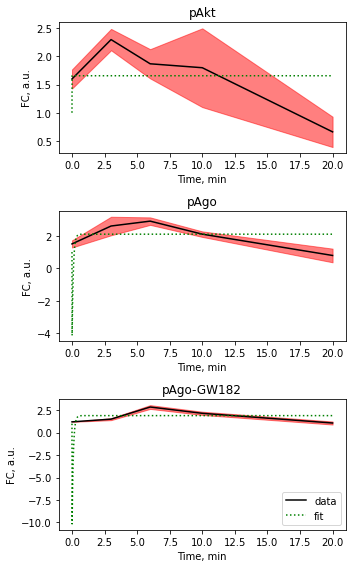

In [62]:
fig, ax = plt.subplots(3, figsize = (5, 8))

Aktp_fold, Agop_fold, Agopgw_fold, time  = foldChange2(res2[0])

for i in range(3):
    ax[i].plot(x_data, 
               data[i][0],
               color = 'black')
    ax[i].plot(time,
               [Aktp_fold, Agop_fold, Agopgw_fold][i],
               color = 'green',
               linestyle = ':')
    ax[i].fill_between(x_data,
                       data[i][0] - data_sem[i][0],
                       data[i][0]+  data_sem[i][0],
                       color = 'red',
                       alpha = 0.5)
    
    ax[i].set_title(['pAkt', 'pAgo', 'pAgo-GW182'][i])
    ax[i].set_ylabel('FC, a.u.')
    ax[i].set_xlabel('Time, min')
    
l1 = mlines.Line2D([],[], linestyle = '-', color = 'black', label = 'data')
l2 = mlines.Line2D([], [], linestyle = ':', color = 'green', label = 'fit')

plt.legend(handles = [l1, l2])


fig.tight_layout()

plt.savefig(r'./plots/model2_optim_3.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

In [14]:
#dat_vals = pd.read_csv('outcmaes_all-optim_gpu2/xrecentbest.dat', delimiter = '\\s', engine = 'python')
res1b = [-2.1891086172494694, -2.4433488194546342, -24.246747947385302, 0.3097092957302445, -5.566253607295039, -0.529244446408704, -7.789006960185361, -9.934601074801321, 9.036872136090096, -25.710634963063058, -20.33791222058062, -51.037103097041836]

In [16]:
#@numba.jit(target_backend = 'cuda')
def model1(theta):
   
    def gauss(x, amp, centre, sigma):
        return amp*np.exp(-(x - centre)**2 / (2*sigma)**2)
   
    k1, k_1, k2, k_2, k3, k_3, Akt0, Aktp0, Ago0, Agop0, Gw0, Agopgw0 = np.exp(theta)
   
    Akt = np.zeros(int((minutes - beg)/dt))
    Aktp = np.zeros(int((minutes - beg)/dt))
    Ago = np.zeros(int((minutes - beg)/dt))
    Agop = np.zeros(int((minutes - beg)/dt))
    Gw = np.zeros(int((minutes - beg)/dt))
    Agopgw = np.zeros(int((minutes - beg)/dt))
    time = np.linspace(int(beg), int(minutes), int((minutes-beg)/dt))
   
    NMDA = gauss(time, amp, centre, sigma)
   
    Akt[0] = Akt0
    Aktp[0] = Aktp0
    Ago[0] = Ago0
    Agop[0] = Agop0
    Gw[0] = Gw0
    Agopgw[0] = Agopgw0
   
    for i in range(1, int((minutes-beg)/dt)):
        Akt[i] = Akt[i-1] + dt*(Aktp[i-1]*k_1 - Akt[i-1]*k1*NMDA[i])
        Aktp[i] = Aktp[i-1] + dt*(Akt[i-1]*k1*NMDA[i] - Aktp[i-1]*k_1)
        Ago[i] = Ago[i-1] + dt*(Agop[i-1]*k_2 - Aktp[i-1]*Ago[i-1]*k2)
        Agop[i] = Agop[i-1] + dt*(Aktp[i-1]*Ago[i-1]*k2 + Agopgw[i-1]*k_3 - Agop[i-1]*k_2 - Agop[i-1]*Gw[i-1]*k3)
        Gw[i] = Gw[i-1] + dt*(Agopgw[i-1]*k_3 - Agop[i-1]*Gw[i-1]*k3)
        Agopgw[i] = Agopgw[i-1] + dt*(Agop[i-1]*Gw[i-1]*k3 - Agopgw[i-1]*k_3)
       
    return Akt, Aktp, Ago, Agop, Gw, Agopgw, NMDA, time

#first simple model function fc calculation
def foldChange1(theta):
    Akt, Aktp, Ago, Agop, Gw, Agopgw, NMDA, time = model1(theta)
   
    Aktp_fold = np.zeros(len(Akt))
    Agop_fold = np.zeros(len(Akt))
    Agopgw_fold = np.zeros(len(Akt))
   
    for i in range(len(Akt)):
            Aktp_fold[i] = Aktp[i] / ( Aktp[0] )#+ Akt[0]) / akcont
            Agop_fold[i] = (Agop[i] + Agopgw[i]) / ( Agop[0]  + Agopgw[0] )#+ Ago[0] ) / agcont
            Agopgw_fold[i] = Agopgw[i] / ( Agopgw[0] )#+ Gw[0]) / gwcont
           
    return Aktp_fold, Agop_fold, Agopgw_fold, time

def error1(theta):
    Aktp_fold, Agop_fold, Agopgw_fold, time = foldChange1(theta)
   
    aktp_model = list(np.interp(x_data, time, Aktp_fold))
    agop_model = list(np.interp(x_data, time, Agop_fold))
    agopgw_model = list(np.interp(x_data, time, Agopgw_fold))
   
    model = np.array([[aktp_model], [agop_model], [agopgw_model]])
   
    return np.sum((data - model)**2)


In [63]:
for i in res1b:
    print(np.exp(i))

0.1120165537522212
0.08686945369849815
2.9496545905557634e-11
1.3630288182352532
0.003824782763032001
0.5890498603252491
0.0004142640604934913
4.84682761129824e-05
8407.438562213689
6.823592910564847e-12
1.470134093011058e-09
6.837034204841468e-23


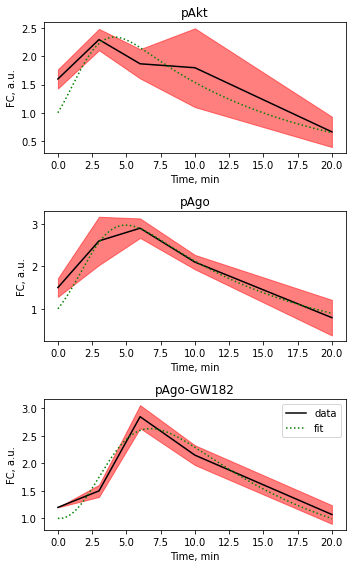

In [17]:
fig, ax = plt.subplots(3, figsize = (5, 8))

Aktp_fold, Agop_fold, Agopgw_fold, time  = foldChange1(res1b)

for i in range(3):
    ax[i].plot(x_data, 
               data[i][0],
               color = 'black')
    ax[i].plot(time,
               [Aktp_fold, Agop_fold, Agopgw_fold][i],
               color = 'green',
               linestyle = ':')
    ax[i].fill_between(x_data,
                       data[i][0] - data_sem[i][0],
                       data[i][0]+  data_sem[i][0],
                       color = 'red',
                       alpha = 0.5)
    
    ax[i].set_title(['pAkt', 'pAgo', 'pAgo-GW182'][i])
    ax[i].set_ylabel('FC, a.u.')
    ax[i].set_xlabel('Time, min')
    
l1 = mlines.Line2D([],[], linestyle = '-', color = 'black', label = 'data')
l2 = mlines.Line2D([], [], linestyle = ':', color = 'green', label = 'fit')

plt.legend(handles = [l1, l2])


fig.tight_layout()

plt.savefig(r'./plots/model1_optim_correct.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

In [18]:
Akt, Aktp, Ago, Agop, Gw, Agopgw, NMDA, time = model1(res1b)

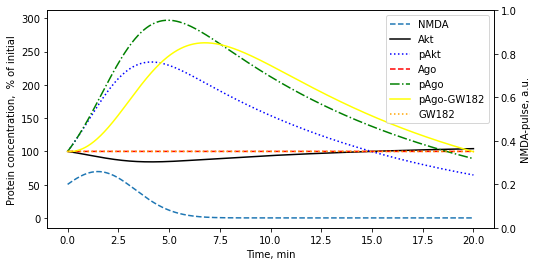

In [72]:
fig, ax = plt.subplots(figsize = (8,4))

ax.plot(time,
        NMDA*100,
        linestyle = '--',
        color = 'C0')
ax.plot(time,
        Akt/(Akt[0])*100, #/(Akt[0]+Aktp[0])*100, #/(Akt[0])*100, #
        linestyle = '-',
        color = 'black')
ax.plot(time,
        Aktp/(Aktp[0])*100, #/(Akt[0]+Aktp[0])*100, #,#/(Aktp[0])*100, #
        linestyle = ':',
        color = 'blue')
ax.plot(time,
        Ago/(Ago[0])*100, #/(Ago[0] + Agop[0] + Agopgw[0])*100, #,#/(Ago[0])*100, #(
        linestyle = '--',
        color = 'red')
ax.plot(time,
        Agop/(Agop[0])*100, #/(Ago[0] + Agop[0] + Agopgw[0])*100, #,#/(Agop[0])*100, #
        linestyle = '-.',
        color = 'green')
ax.plot(time,
        Agopgw/(Agopgw[0])*100, #/(Agopgw[0] + Gw[0])*100, #,#/(Agopgw[0])*100, #
        linestyle = '-',
        color = 'yellow')
ax.plot(time,
        Gw/(Gw[0])*100, #/(Agopgw[0] + Gw[0])*100, #,#/(Gw[0])*100, #
        linestyle = ':',
        color = 'orange')

ax.set_ylabel('Protein concentration,  % of initial')
ax.set_xlabel('Time, min')

ax2 = ax.twinx()
ax2.set_ylabel('NMDA-pulse, a.u.')

l0 = mlines.Line2D([], [], linestyle = '--', color = 'C0', label = 'NMDA')
l1 = mlines.Line2D([], [], linestyle = '-', color = 'black', label = 'Akt')
l2 = mlines.Line2D([], [], linestyle = ':', color = 'blue', label = 'pAkt')
l3 = mlines.Line2D([], [], linestyle = '--', color = 'red', label = 'Ago')
l4 = mlines.Line2D([], [], linestyle = '-.', color = 'green', label = 'pAgo')
l5 = mlines.Line2D([], [], linestyle = '-', color = 'yellow', label = 'pAgo-GW182')
l6 = mlines.Line2D([], [], linestyle = ':', color = 'orange', label = 'GW182')

plt.legend(handles = [l0, l1, l2, l3, l4, l5, l6], loc = 1)

fig.savefig(r'./plots/protein_dynamics-model1.svg', dpi = 600, bbox_inches = 'tight')

plt.show()

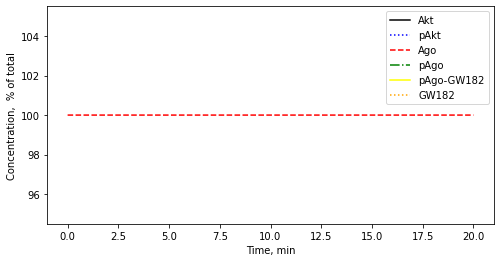

In [65]:
fig, ax = plt.subplots(figsize = (8,4))

#ax.plot(time,
#        Akt/(Akt[0]+Aktp[0])*100, #/(Akt[0])*100, #
#        linestyle = '-',
#        color = 'black')
#ax.plot(time,
#        Aktp/(Akt[0]+Aktp[0])*100, #,#/(Aktp[0])*100, #
#        linestyle = ':',
#        color = 'blue')
ax.plot(time,
        Ago/(Ago[0])*100, #,#/(Ago[0])*100, #(
        linestyle = '--',
        color = 'red')
#ax.plot(time,
#        Agop/(Ago[0] + Agop[0] + Agopgw[0])*100, #,#/(Agop[0])*100, #
#        linestyle = '-.',
#        color = 'green')
#ax.plot(time,
#        Agopgw/(Agopgw[0] + Gw[0])*100, #,#/(Agopgw[0])*100, #
#        linestyle = '-',
#        color = 'yellow')
#ax.plot(time,
#        Gw/(Agopgw[0] + Gw[0])*100, #,#/(Gw[0])*100, #
#        linestyle = ':',
#        color = 'orange')

ax.set_ylabel('Concentration,  % of total')
ax.set_xlabel('Time, min')

l1 = mlines.Line2D([], [], linestyle = '-', color = 'black', label = 'Akt')
l2 = mlines.Line2D([], [], linestyle = ':', color = 'blue', label = 'pAkt')
l3 = mlines.Line2D([], [], linestyle = '--', color = 'red', label = 'Ago')
l4 = mlines.Line2D([], [], linestyle = '-.', color = 'green', label = 'pAgo')
l5 = mlines.Line2D([], [], linestyle = '-', color = 'yellow', label = 'pAgo-GW182')
l6 = mlines.Line2D([], [], linestyle = ':', color = 'orange', label = 'GW182')

plt.legend(handles = [l1, l2, l3, l4, l5, l6], loc = 1)


plt.show()

In [3]:
#first simple model function

@numba.jit()
def model3(theta):
    
    def gauss(x, amp, centre, sigma):
        return amp*np.exp(-(x - centre)**2 / (2*sigma)**2) 
    
    k1, k_1, k2, k_2, k3, k_3, Akt0, Aktp0, Ago0, Agop0, Gw0, Agopgw0 = np.exp(theta)
    
    Akt = np.zeros(int((minutes - beg2)/dt))
    Aktp = np.zeros(int((minutes - beg2)/dt))
    Ago = np.zeros(int((minutes - beg2)/dt))
    Agop = np.zeros(int((minutes - beg2)/dt))
    Gw = np.zeros(int((minutes - beg2)/dt))
    Agopgw = np.zeros(int((minutes - beg2)/dt))
    time = np.linspace(int(beg2), int(minutes), int((minutes-beg2)/dt))
    
    NMDA = gauss(time, amp, centre, sigma)
    
    Akt[0] = Akt0
    Aktp[0] = Aktp0
    Ago[0] = Ago0
    Agop[0] = Agop0
    Gw[0] = Gw0
    Agopgw[0] = Agopgw0
    
    for i in range(1, int((minutes-beg)/dt)):
        Akt[i] = Akt[i-1] + dt*(Aktp[i-1]*k_1 - Akt[i-1]*k1*NMDA[i])
        Aktp[i] = Aktp[i-1] + dt*(Akt[i-1]*k1*NMDA[i] - Aktp[i-1]*k_1)
        Ago[i] = Ago[i-1] + dt*(Agop[i-1]*k_2 - Aktp[i-1]*Ago[i-1]*k2)
        Agop[i] = Agop[i-1] + dt*(Aktp[i-1]*Ago[i-1]*k2 + Agopgw[i-1]*k_3 - Agop[i-1]*k_2 - Agop[i-1]*Gw[i-1]*k3)
        Gw[i] = Gw[i-1] + dt*(Agopgw[i-1]*k_3 - Agop[i-1]*Gw[i-1]*k3)
        Agopgw[i] = Agopgw[i-1] + dt*(Agop[i-1]*Gw[i-1]*k3 - Agopgw[i-1]*k_3)
        
    return Akt, Aktp, Ago, Agop, Gw, Agopgw, NMDA, time

In [4]:
#first simple model function fc calculation
def foldChange3(theta):
    Akt, Aktp, Ago, Agop, Gw, Agopgw, NMDA, time = model3(theta)
    
    Aktp_fold = np.zeros(len(Akt))
    Agop_fold = np.zeros(len(Akt))
    Agopgw_fold = np.zeros(len(Akt))
    
    for i in range(len(Akt)):
            Aktp_fold[i] = Aktp[i] / ( Aktp[0] )#+ Akt[0]) / akcont
            Agop_fold[i] = (Agop[i] + Agopgw[i]) / ( Agop[0]  + Agopgw[0] )#+ Ago[0] ) / agcont
            Agopgw_fold[i] = Agopgw[i] / ( Agopgw[0] )#+ Gw[0]) / gwcont
            
    return Aktp_fold, Agop_fold, Agopgw_fold, time 

In [5]:
def error3(theta):
    Aktp_fold, Agop_fold, Agopgw_fold, time = foldChange3(theta)
    
    aktp_model = list(np.interp(x_data2, time, Aktp_fold))
    agop_model = list(np.interp(x_data2, time, Agop_fold))
    agopgw_model = list(np.interp(x_data2, time, Agopgw_fold))
    
    model = np.array([[aktp_model], [agop_model], [agopgw_model]])
    
    return np.sum((data2 - model)**2)

In [6]:
res3 = cma.fmin(error3, theta, 2)

(5_w,11)-aCMA-ES (mu_w=3.4,w_1=42%) in dimension 12 (seed=871629, Fri Aug 16 07:33:08 2024)


C:\Users\Sofia\AppData\Local\Temp/ipykernel_14112/741620123.py:11: RuntimeWarning: invalid value encountered in double_scalars
  Agop_fold[i] = (Agop[i] + Agopgw[i]) / ( Agop[0]  + Agopgw[0] )#+ Ago[0] ) / agcont


Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     11 2.112313568978488e+01 1.0e+00 1.84e+00  2e+00  2e+00 0:00.0
    2     22 1.515526993053058e+01 1.1e+00 1.72e+00  2e+00  2e+00 0:00.1


C:\Users\Sofia\AppData\Local\Temp/ipykernel_14112/741620123.py:11: RuntimeWarning: invalid value encountered in double_scalars
  Agop_fold[i] = (Agop[i] + Agopgw[i]) / ( Agop[0]  + Agopgw[0] )#+ Ago[0] ) / agcont
C:\Users\Sofia\AppData\Local\Temp/ipykernel_14112/4259475712.py:10: RuntimeWarning: overflow encountered in square
  return np.sum((data2 - model)**2)


    3     33 1.887552847698828e+01 1.2e+00 1.68e+00  2e+00  2e+00 0:00.1
  100   1100 6.118926966000214e+00 9.9e+00 2.84e-01  2e-01  4e-01 0:02.9
  200   2200 3.559719121851489e+00 6.8e+01 6.39e-01  3e-01  1e+00 0:05.6
  300   3300 3.441432442801293e+00 2.7e+02 2.88e-01  5e-02  6e-01 0:08.3
  400   4400 3.383929468901770e+00 2.1e+02 4.87e-01  4e-02  8e-01 0:11.0
  500   5500 3.069045825905210e+00 7.5e+02 6.73e-01  6e-02  2e+00 0:13.6
  600   6600 2.935700807006580e+00 4.8e+03 5.09e-01  3e-02  4e+00 0:16.3
  700   7700 2.931632036740430e+00 6.7e+04 9.82e-02  3e-03  3e+00 0:19.0
NOTE (module=cma, iteration=763):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 2.7e+11 to 2.7e+11
  800   8800 2.931610402745008e+00 9.7e+05 1.11e-02  1e-04  2e+00 0:21.6


C:\Users\Sofia\anaconda3\lib\site-packages\cma\utilities\utils.py:347: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.1e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=802)
  warnings.warn(msg + ' (' +


  900   9900 2.931610340033553e+00 2.2e+01 3.60e-03  1e-03  1e-02 0:24.3
  969  10659 2.931610339874207e+00 1.3e+01 9.84e-05  2e-05  1e-04 0:26.8
termination on tolfun=1e-11 (Fri Aug 16 07:33:38 2024)
final/bestever f-value = 2.931610e+00 2.931610e+00 after 10660/10582 evaluations
incumbent solution: [-3.83856317e-01 -4.13747171e+00 -5.59011777e+01 -6.25655182e-01
 -4.35443577e+02 -9.63899473e-01 -1.55663515e+02 -1.56199921e+02 ...]
std deviations: [3.39190351e-05 3.13909702e-05 1.02452689e-04 1.96614990e-05
 4.93353579e-05 2.69752108e-05 9.45134288e-05 1.08445353e-04 ...]


In [7]:
os.renames('outcmaes', 'outcmaes_all-steady')

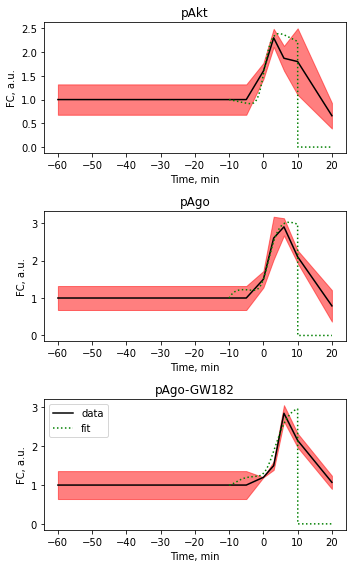

In [10]:
fig, ax = plt.subplots(3, figsize = (5, 8))

Aktp_fold, Agop_fold, Agopgw_fold, time  = foldChange3(res3[0])

for i in range(3):
    ax[i].plot(x_data2, 
               data2[i][0],
               color = 'black')
    ax[i].plot(time,
               [Aktp_fold, Agop_fold, Agopgw_fold][i],
               color = 'green',
               linestyle = ':')
    ax[i].fill_between(x_data2,
                       data2[i][0] - data_sem2[i][0],
                       data2[i][0]+  data_sem2[i][0],
                       color = 'red',
                       alpha = 0.5)
    
    ax[i].set_title(['pAkt', 'pAgo', 'pAgo-GW182'][i])
    ax[i].set_ylabel('FC, a.u.')
    ax[i].set_xlabel('Time, min')
    
l1 = mlines.Line2D([],[], linestyle = '-', color = 'black', label = 'data')
l2 = mlines.Line2D([], [], linestyle = ':', color = 'green', label = 'fit')

plt.legend(handles = [l1, l2])


fig.tight_layout()

plt.savefig(r'./plots/model1_optim_steady.svg', dpi = 600, bbox_inches = 'tight')

plt.show()